In [70]:
using Falcons
using Healpix
using StatsBase
using PyCall
using Base.Threads
using Formatting
using Statistics
using Printf
using NPZ
using NaNStatistics
using PyPlot
hp = pyimport("healpy")
np = pyimport("numpy")
include("/gpfs/home/cmb/yusuket/program/scan_strategy/optimisation2/functions/systematics_func.jl");

In [51]:
function get_scanfield(SS::ScanningStrategy,; division::Int, spin_n::AA, spin_m::AA) where {AA<:AbstractArray}
    h = orientation_func_hwp
    resol = Resolution(SS.nside)
    npix = nside2npix(SS.nside)
    chunk = Int(SS.duration / division)
    ω_hwp = rpm2angfreq(SS.hwp_rpm)
    hitmap = zeros(Int64, npix)
    hₙₘ = zeros(Complex{Float64}, (length(spin_n), length(spin_m), npix))
    BEGIN = 0
    p = Progress(division)
    @views @inbounds for i = 1:division
        END = i * chunk
        pix_tod, psi_tod, time_array = get_pointing_pixels(SS, BEGIN, END)
        @views @inbounds for j = eachindex(psi_tod[1,:])
            pix_tod_jth_det = pix_tod[:,j]
            psi_tod_jth_det = psi_tod[:,j]
            @views @inbounds @simd for k = eachindex(psi_tod[:,1])
                t = time_array[k]
                Ωₖ = pix_tod_jth_det[k]
                ψₖ = psi_tod_jth_det[k]
                ϕ_hwp = mod2pi(ω_hwp*t)
                hitmap[Ωₖ] += 1
                @views @inbounds for _n_ in eachindex(spin_n)
                    @views @inbounds for _m_ in eachindex(spin_m)
                        hₙₘ[_n_, _m_, Ωₖ] += h(spin_n[_n_], spin_m[_m_], ψₖ, ϕ_hwp)
                    end
                end
            end
        end
        BEGIN = END
        next!(p)
    end
    @views for _n_ in eachindex(spin_n)
        @views for _m_ in eachindex(spin_m)
            hₙₘ[_n_,_m_,:] ./= hitmap
        end
    end
    #=
    outmap = Dict{String, Array}(
        "hitmap" => hitmap,
        "h" => hₙₘ,
        )
    =#
    return scanfield(hitmap, hₙₘ, spin_n, spin_m)
end

mutable struct scanfield{T<:Int64, AA<:AbstractArray{T,1}}
    hitmap::AA
    h::Array
    n::AA
    m::AA
end

In [52]:
day = 60 * 60 * 24
year = day * 365
ss = gen_ScanningStrategy()
ss.duration = year;

spin_n = -5:5 |> collect
spin_m = [-8,-4,0,4,8]
field = get_scanfield(ss, division=6, spin_n=spin_n, spin_m=spin_m);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:36


In [76]:
function h_nm(field::scanfield, n::Int,m::Int)
    fn(i) = findall(x->x==i, field.n)[1]
    fm(i) = findall(x->x==i, field.m)[1]
    field.h[fn(n), fm(m),:]
end

function gen_input(;nside, seed=1, fwhm_deg, g_off=0, rho_arcmin, chi_deg)
    lmax = 3*nside - 1
    inputmap_path = "/home/cmb/yusuket/program/scan_strategy/optimization/alpha_beta_2D/spin_char/simple_model_spectrum.npz"
    power_spectrum_data = npzread(inputmap_path)
    np.random.seed(seed)
    origin_map = hp.synfast(power_spectrum_data["total"]|>transpose, nside, new=true, fwhm=deg2rad(fwhm_deg))
    inputinfo = set_input(inputmap=origin_map)
    inputinfo.Systematics.Gain.offset = [g_off]
    inputinfo.Systematics.Pointing.offset_ρ = [deg2rad(rho_arcmin/60.)]
    inputinfo.Systematics.Pointing.offset_χ = [chi_deg]
    return inputinfo
end

input = gen_input(nside=128, seed=1, fwhm_deg=0.5, g_off=0, rho_arcmin=1, chi_deg=0);

In [77]:
function abs_point(Ω, ϕ, ψ, Imap, Pmap, dI, dQ, dU, II::Falcons.InputInfo)
    ∂I = @views dI[3,Ω] - dI[2,Ω]im
    ∂P = @views dQ[3,Ω] + dU[2,Ω] - (dQ[2,Ω] - dU[3,Ω])im
    ∂̄P = @views dQ[3,Ω] - dU[2,Ω] + (dQ[2,Ω] + dU[3,Ω])im
    I = Imap[Ω]
    P = Pmap[Ω] 
    ρ = II.Systematics.Pointing.offset_ρ[1]
    χ = II.Systematics.Pointing.offset_χ[1]
    I1 = I - (ρ/2)*(ℯ^(im*(ψ+χ))*∂I + ℯ^(-im*(ψ+χ))*conj(∂I))
    P1 = (1/2) * (P*ℯ^(im*(2ψ+4ϕ))        - (ρ/2) * (ℯ^(im*(3ψ+4ϕ+χ))*∂P       + ℯ^(im*(ψ+4ϕ-χ))*∂̄P ))
    P2 = (1/2) * (conj(P)*ℯ^(-im*(2ψ+4ϕ)) - (ρ/2) * (ℯ^(im*(-ψ-4ϕ+χ))*conj(∂̄P) + ℯ^(im*(-3ψ-4ϕ-χ))*conj(∂P) ))
    return I1 + P1 + P2
end

function pointing_offset_hwp(field::scanfield, inputinfo::Falcons.InputInfo)
    n(i) = findall(x->x==i, field.n)[1]
    m(i) = findall(x->x==i, field.m)[1]
    
    Imap = inputinfo.Inputmap.i.pixels
    Pmap = inputinfo.Inputmap.q.pixels .+ (inputinfo.Inputmap.u.pixels)im
    npix = length(Imap)

    alm_I = hp.map2alm(Imap)
    alm_Q = hp.map2alm(real.(Pmap))
    alm_U = hp.map2alm(imag.(Pmap))
    dI = hp.alm2map_der1(alm_I, npix2nside(length(inputinfo.Inputmap.i.pixels)))
    dQ = hp.alm2map_der1(alm_Q, npix2nside(length(inputinfo.Inputmap.i.pixels)))
    dU = hp.alm2map_der1(alm_U, npix2nside(length(inputinfo.Inputmap.i.pixels)));
    
    ρ = inputinfo.Systematics.Pointing.offset_ρ[1]
    χ = inputinfo.Systematics.Pointing.offset_χ[1]
    ∂I = @. dI[3,:] - dI[2,:]im
    ∂P = @. dQ[3,:] + dU[2,:] - (dQ[2,:] - dU[3,:])im
    ∂̄P = @. dQ[3,:] - dU[2,:] + (dQ[2,:] + dU[3,:])im

    S_00 = Imap
    S_10 = @. -(ρ/2)*ℯ^(im*χ)*∂I
    S_14 = @. -(ρ/4)*ℯ^(-im*χ)*∂̄P
    S_24 = @. Pmap/2
    S_34 = @. -(ρ/4)*ℯ^(im*χ)*∂P

    h̃ = field.h
    ₊₀₀Sᵈ = @views h̃[n(3),m(4),:]   .*conj.(S_34) .+ h̃[n(2),m(4),:].*conj.(S_24)  .+ h̃[n(1),m(4),:].*conj.(S_14) .+ 
            h̃[n(1),m(0),:]   .*conj.(S_10) .+ S_00                         .+ h̃[n(-1),m(0),:].*S_10       .+   
            h̃[n(-1),m(-4),:] .*S_14        .+ h̃[n(-2),m(-4),:].*S_24       .+ h̃[n(-3),m(-4),:].*S_34

    ₊₂₄Sᵈ  = @views h̃[n(5),m(8),:] .*conj.(S_34) .+ h̃[n(4),m(8),:].*conj.(S_24)  .+ h̃[n(3),m(8),:] .*conj.(S_14) .+
             h̃[n(3),m(4),:] .*conj.(S_10) .+ h̃[n(2),m(4),:].*S_00         .+ h̃[n(1),m(4),:] .*S_10        .+
             h̃[n(1),m(0),:] .*S_14        .+ S_24                         .+ h̃[n(-1),m(0),:].*S_34

    ₋₂₋₄Sᵈ = @views h̃[n(1),m(0),:]   .*conj.(S_34) .+ conj.(S_24)                .+ h̃[n(-1),m(0),:] .*conj.(S_14) .+
             h̃[n(-1),m(-4),:] .*conj.(S_10) .+ h̃[n(-2),m(-4),:].*S_00     .+ h̃[n(-3),m(-4),:].*S_10        .+
             h̃[n(-3),m(-8),:] .*S_14        .+ h̃[n(-4),m(-8),:].*S_24     .+ h̃[n(-5),m(-8),:].*S_34;
    signal = zeros(Complex{Float64}, (3, 1, npix))
    maps = zeros(Complex{Float64}, (3, 1, npix))

    signal[1,1,:] .= @views ₊₀₀Sᵈ
    signal[2,1,:] .= @views ₋₂₋₄Sᵈ/2
    signal[3,1,:] .= @views ₊₂₄Sᵈ/2
    
    hitmat = zeros(Complex{Float64}, (3, 3, npix))
    hitmat[1,1,:] .= ones(npix)
    hitmat[1,2,:] .= 1/2 .* h̃[n(-2),m(-4),:]
    hitmat[1,3,:] .= 1/2 .* h̃[n(2),m(4),:]
    hitmat[2,1,:] .= 1/2 .* h̃[n(-2),m(-4),:]
    hitmat[2,2,:] .= 1/4 .* h̃[n(-4),m(-8),:]
    hitmat[2,3,:] .= 1/4 .* ones(npix)
    hitmat[3,1,:] .= 1/2 .* h̃[n(2),m(4),:]
    hitmat[3,2,:] .= 1/4 .* ones(npix)
    hitmat[3,3,:] .= 1/4 .* h̃[n(-4),m(-8),:]
    
    @inbounds @threads for j = eachindex(signal[1,1,:])
        maps[:, :, j] = hitmat[:, :, j] \ signal[:, :, j]
    end
    return mapbase = [real.(maps[1,1,:]) real.(maps[2,1,:]) imag.(maps[2,1,:])] |> transpose
end


pointing_offset_hwp (generic function with 2 methods)

In [78]:
maps = pointing_offset_hwp(field, input)

3×196608 transpose(::Matrix{Float64}) with eltype Float64:
 34.453     26.8199    77.9362    …  127.393     71.7698    99.7426
  0.950159   0.560752   0.393025       0.226096  -0.648763   1.91428
 -1.61133   -0.857188   0.658779       2.12434    0.48324   -0.924489

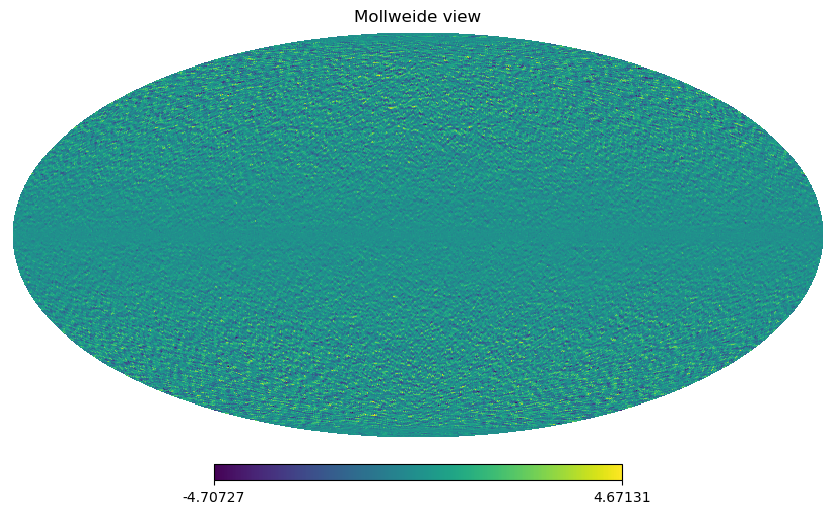

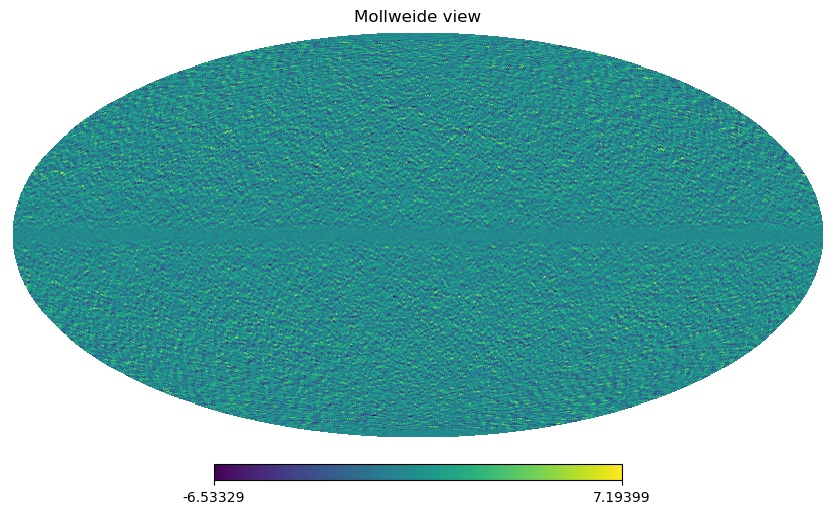

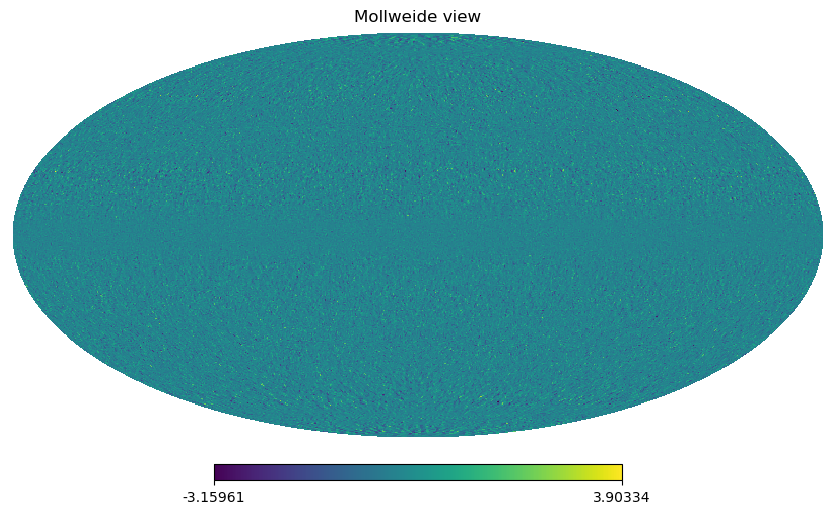

In [79]:
hp.mollview(maps[1,:] .- input.Inputmap.i)
hp.mollview(maps[2,:] .- input.Inputmap.q)
hp.mollview(maps[3,:] .- input.Inputmap.u)